### Import Libraries

In [ ]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip

Streaming output truncated to the last 5000 lines.
  inflating: ECGDataDenoised/MUSE_20180116_125802_57000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125812_73000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125822_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125825_58000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125842_09000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125845_27000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125847_39000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125906_02000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125918_29000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125919_34000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125921_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125925_64000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125946_45000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_125948_54000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130000_80000.csv  
  inflating: ECGDat

In [1]:
!pip install -q -U tensorflow_addons
!pip install neurokit2
# !pip install wfdb

     |████████████████████████████████| 1.1 MB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 4.5 MB/s 


In [2]:
import sys
import os

from tensorflow.keras.layers import BatchNormalization
%matplotlib inline
sampling_rate=500
arr_folder_location = "/content/drive/MyDrive/Arrythmia /"
sys.path.append(os.path.abspath(arr_folder_location))

In [3]:
from arryhthmia_backend import *

File Import Success


In [ ]:
def extractor(case,id):
  cnt_id={}
  nsr_det_rri = []
  nsr_det_rri = np.array(nsr_det_rri)
  afib_det_rri = []
  afib_det_rri = np.array(afib_det_rri)
  afl_det_rri = []
  afl_det_rri = np.array(afl_det_rri)
  afl_list = []
  for i in id:
    label=subject_label[all_subjects[i]]
    if label in cnt_id:
      cnt_id[label]+=1
    else:
      cnt_id[label]=1
    name=all_subjects[i]
    if(label=='nsr'):
      nsr_det_rri=np.append(nsr_det_rri,nsr_rri[name])
    elif(label=='afl'):
      afl_list.append(name)
      afl_det_rri=np.append(afl_det_rri,afl_rri[name])
    else:
      afib_det_rri=np.append(afib_det_rri,afib_rri[name])
    ## 
  print(case,":",cnt_id)
  print(len(afib_det_rri),len(nsr_det_rri),len(afl_det_rri))

  p1 = np.random.permutation(afl_list)
  p2 = np.random.permutation(afl_list)
  # print(len(p1)," , ",len(p2))
  for k in p1:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  for k in p2:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  print("After patient Scrambling:",len(afl_det_rri))


  afib_vectors = round_robin(afib_det_rri)
  afl_vectors = round_robin(afl_det_rri)
  nsr_vectors = round_robin(nsr_det_rri)
  len__puncture = min(len(afib_vectors),min(len(nsr_vectors),len(afl_vectors)))
  afib_vectors = afib_vectors[:len__puncture]
  afl_vectors = afl_vectors[:len__puncture]
  nsr_vectors = nsr_vectors[:len__puncture]

  afib_rr = pd.DataFrame(afib_vectors)
  afib_rr['label']='afib'
  nsr_rr = pd.DataFrame(nsr_vectors)
  nsr_rr['label']='nsr'
  afl_rr = pd.DataFrame(afl_vectors)
  afl_rr['label']='afl'

  full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])
  dict = {'nsr': 0, 'afib': 1, 'afl':2}
  full_data_with_rr.replace({'label': dict},inplace=True)
  return full_data_with_rr



def train_1_fold(train,test,NN,num_epochs):
    # train=pd.read_csv("/content/drive/MyDrive/train_with_rr_20.csv")
    train = train.sample(frac=1).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)
    full_data_with_rr=train
    full_test_set=test

    X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values,test_size=0.1, random_state=42)

    X_arhy_test, X_arhy_val, y_arhy_test, y_arhy_val = train_test_split(X_arhy_val,y_arhy_val,test_size=0.5, random_state=42)

    # The 1D convolutions expect an extra dimension in the input data 
    X_arhyl_train = np.expand_dims(X_arhy_train, -1)
    y_arhyl_train = np.expand_dims(y_arhy_train, -1)
    X_arhyl_val = np.expand_dims(X_arhy_val, -1)
    y_arhyl_val = np.expand_dims(y_arhy_val, -1)
    X_arhyl_test = np.expand_dims(X_arhy_test, -1)
    y_arhyl_test = np.expand_dims(y_arhy_test, -1)

    N = X_arhyl_train.shape[0]
    batch_size = 128
    iterations = N/batch_size
    step_size= 2 * iterations

    optimizer = keras.optimizers.Adam(lr=0.001)
    model = get_resnet_model(5) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-02, max_steps=50, smoothing=0.6)
    _ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=num_epochs, callbacks=[lr_finder], verbose=False)
    lr_finder.plot()

    lr_schedule = CyclicalLearningRate(1e-5, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    m_resnet_model = get_resnet_model(NN)

    save_best_weights = ModelCheckpoint(filepath="/content/drive/My Drive/Arrythmia /weights.hdf5", verbose=0, save_best_only=True)

    m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = m_resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                                shuffle=True, batch_size=128, epochs=num_epochs, callbacks=[save_best_weights])
    pretty_plot(history, 'loss', lambda x: np.argmin(x))
    pretty_plot(history, 'accuracy', lambda x: np.argmax(x))
    m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
    print("\n****** Val data (used to tune hyperparameters for model) *****\n")
    test_stats = m_resnet_model.evaluate(X_arhyl_test, y_arhyl_test)   
    test_acc = round(test_stats[1],2)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhyl_test), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')

    X_arhy_test_10split = full_test_set.iloc[:,:-1].values
    y_arhy_test_10split = full_test_set.iloc[:,-1].values

    print("\n****** Validation data (unseen to model) *****\n")
    ###########
    val_stats=m_resnet_model.evaluate(X_arhy_test_10split, y_arhy_test_10split)
    val_acc = round(val_stats[1],4)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhy_test_10split), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test_10split, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR', 'AFIB','AFL'],
                        title='Confusion matrix, without normalization')
    
    print("Final Accuracy:",val_acc*100,"%\n")
    return float(val_acc*100)


In [ ]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
len(labels)

10646

In [ ]:
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

### Preprocessing

In [ ]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
afib_files.remove('MUSE_20180116_131253_72000')
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()
all_files = afib_files+nsr_files+afl_files

In [ ]:
nsr_rri=append_r_peaks(nsr_files,"nsr",sampling_rate=500)
afib_rri=append_r_peaks(afib_files,"afib",sampling_rate=500)
afl_rri=append_r_peaks(afl_files,"afl",sampling_rate=500)
# to verify total no. of total RR Intervals for each class and 
# Extract RR Peaks into a dictionary with filename

100%|██████████| 1826/1826 [00:30<00:00, 59.52it/s]


Total no. of RR Intervals in nsr  class is: 20520 



 91%|█████████ | 1618/1779 [00:26<00:02, 58.44it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1779/1779 [00:29<00:00, 60.32it/s]


Total no. of RR Intervals in afib  class is: 25124 



100%|██████████| 445/445 [00:08<00:00, 54.72it/s]

Total no. of RR Intervals in afl  class is: 7491 



In [ ]:
# nsr_extraction_rr = pd.DataFrame.from_dict(nsr_rri,orient='index')
# afl_extraction_rr = pd.DataFrame.from_dict(afl_rri,orient='index')
# afib_extraction_rr = pd.DataFrame.from_dict(afib_rri,orient='index')

In [ ]:
all_subjects=all_files
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

### Labelling encoding {'nsr': 0, 'afib': 1, 'afl':2}


In [ ]:
def get_resnet_model(categories=3): #original
  def residual_block(X, kernels, stride,F_size):
    out = tf.keras.layers.Conv1D(F_size,kernels, stride, padding='same')(X)
    # out = BatchNormalization()(out)
    out = tf.keras.activations.relu(out)    
    out = tf.keras.layers.add([X, out])
    out = tf.keras.layers.MaxPool1D(1, 3)(out)
    return out

  kernels = 32
  stride = 1

  ### INPUT
  inputs = tf.keras.layers.Input([100,1])
  ### BLOCK 1
  X = tf.keras.layers.Conv1D(64,8, stride)(inputs)  
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(64,5, stride)(inputs)  
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(64,3, stride)(inputs)  
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)

  ### Residual Block
  X = residual_block(X, kernels, stride,64)
  X = tf.keras.activations.relu(X)  

  ### BLOCK 2
  X = tf.keras.layers.Conv1D(128,8, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(128,5, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(128,3, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)

  ### Residual Block  
  X = residual_block(X, kernels, stride,128)
  X = tf.keras.activations.relu(X)  

  ### BLOCK 3
  X = tf.keras.layers.Conv1D(128,8, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(128,5, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  X = tf.keras.layers.Conv1D(128,3, stride)(inputs)
  X = tf.keras.activations.relu(X)
  # X = BatchNormalization()(X)
  
  ### Residual Block  
  X = residual_block(X, kernels, stride,128)
  
  # X = tf.keras.layers.Flatten()(X)
  X = tf.keras.layers.GlobalAveragePooling1D()(X)

  # X = tf.keras.layers.Dense(64, activation='relu')(X)
  # X = tf.keras.layers.Dense(32, activation='relu')(X)
  X = tf.keras.layers.Dense(8, activation='relu')(X)

  output = (tf.keras.layers.Dense(1, activation='sigmoid')(X) if categories == 3 else tf.keras.layers.Dense(5, activation='softmax')(X))

  model = tf.keras.Model(inputs=inputs, outputs=output)
  return model


train : {'afib': 1592, 'nsr': 1652, 'afl': 401}
22573 18567 6786
After patient Scrambling: 20358


100%|██████████| 18567/18567 [00:00<00:00, 373923.94it/s]


test : {'afib': 187, 'nsr': 174, 'afl': 44}
2551 1953 705
After patient Scrambling: 2115


100%|██████████| 1953/1953 [00:00<00:00, 638363.13it/s]



#@#@#@#@#@ Working on FOLD: 1 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
392/392 [==============================] - 6s 13ms/step - loss: 0.5304 - accuracy: 0.7957 - val_loss: 0.2710 - val_accuracy: 0.8837
Epoch 2/8
392/392 [==============================] - 4s 10ms/step - loss: 0.2227 - accuracy: 0.9116 - val_loss: 0.1603 - val_accuracy: 0.9458
Epoch 3/8
392/392 [==============================] - 4s 10ms/step - loss: 0.1180 - accuracy: 0.9543 - val_loss: 0.0774 - val_accuracy: 0.9724
Epoch 4/8
392/392 [==============================] - 4s 10ms/step - loss: 0.0634 - accuracy: 0.9776 - val_loss: 0.0524 - val_accuracy: 0.9792
Epoch 5/8
392/392 [==============================] - 4s 10ms/step - loss: 0.0540 - accuracy: 0.9811 - val_loss: 0.0692 - val_accuracy: 0.9738
Epoch 6/8
392/392 [==============================] - 4s 10ms/step - loss: 0.0553 - accuracy: 0.9808 - val_loss: 0.0336 - val_accuracy: 0.9889
Epoch 7/8
392/392 [==============================] - 4s 10ms/step - loss: 0.0289 - accuracy: 0.9907 - val_loss: 0.0140 - val_accuracy: 0.9961
Epoch 

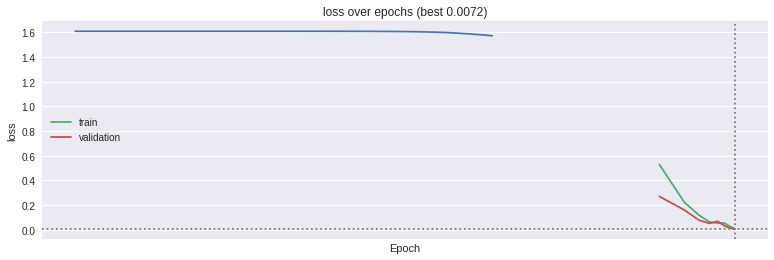

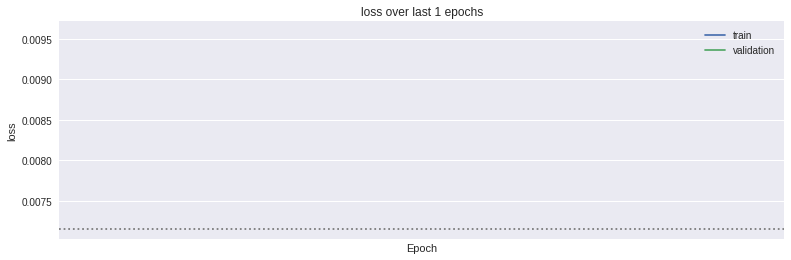

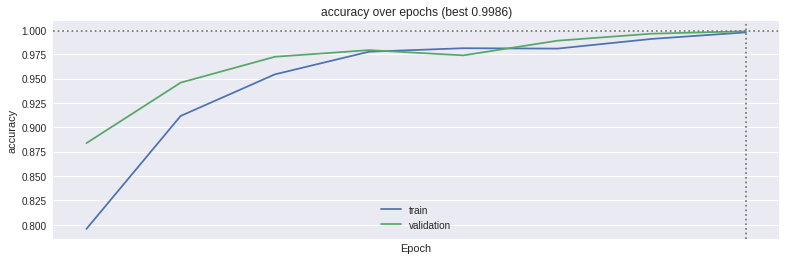

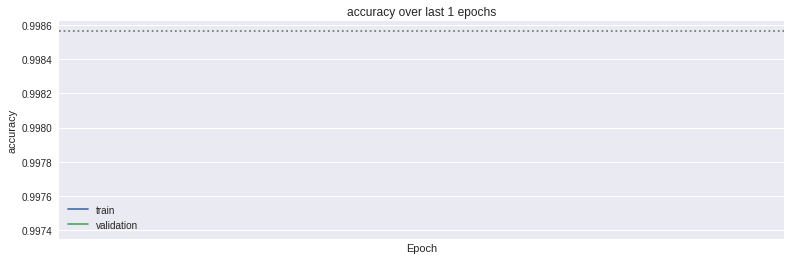


****** Val data (used to tune hyperparameters for model) *****

88/88 [==============================] - 0s 3ms/step - loss: 0.0087 - accuracy: 0.9975
Confusion matrix, without normalization
[[916   0   0]
 [  0 934   0]
 [  2   5 928]]

****** Validation data (unseen to model) *****

184/184 [==============================] - 1s 3ms/step - loss: 0.1212 - accuracy: 0.9715
Confusion matrix, without normalization
[[1953    0    0]
 [   0 1889   64]
 [   0  103 1850]]
Final Accuracy: 97.15 %

train : {'afib': 1587, 'nsr': 1650, 'afl': 408}
22383 18526 6843
After patient Scrambling: 20529


100%|██████████| 18526/18526 [00:00<00:00, 479108.15it/s]


test : {'afib': 192, 'nsr': 176, 'afl': 37}
2741 1994 648
After patient Scrambling: 1944


100%|██████████| 1994/1994 [00:00<00:00, 624370.45it/s]



#@#@#@#@#@ Working on FOLD: 2 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 5s 12ms/step - loss: 0.6555 - accuracy: 0.7334 - val_loss: 0.3666 - val_accuracy: 0.8370
Epoch 2/8
391/391 [==============================] - 4s 10ms/step - loss: 0.2701 - accuracy: 0.8917 - val_loss: 0.2314 - val_accuracy: 0.9158
Epoch 3/8
391/391 [==============================] - 4s 10ms/step - loss: 0.1948 - accuracy: 0.9254 - val_loss: 0.1486 - val_accuracy: 0.9449
Epoch 4/8
391/391 [==============================] - 4s 10ms/step - loss: 0.1279 - accuracy: 0.9548 - val_loss: 0.1057 - val_accuracy: 0.9601
Epoch 5/8
391/391 [==============================] - 4s 10ms/step - loss: 0.1122 - accuracy: 0.9610 - val_loss: 0.1020 - val_accuracy: 0.9615
Epoch 6/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0975 - accuracy: 0.9658 - val_loss: 0.0736 - val_accuracy: 0.9741
Epoch 7/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0627 - accuracy: 0.9773 - val_loss: 0.0370 - val_accuracy: 0.9870
Epoch 

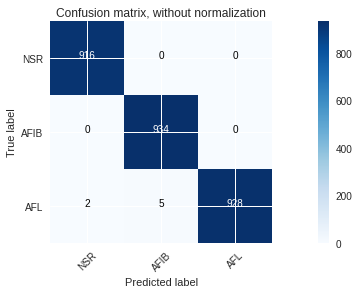

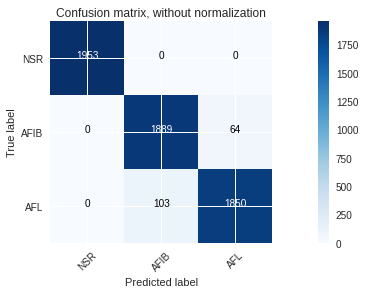

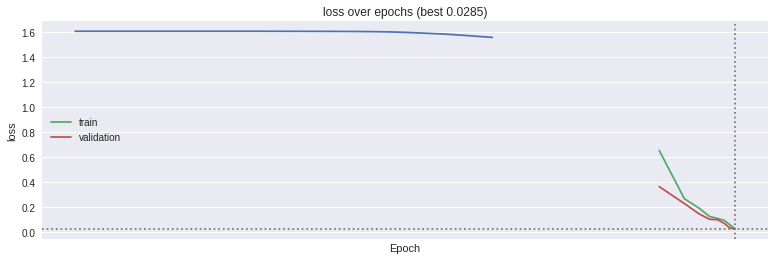

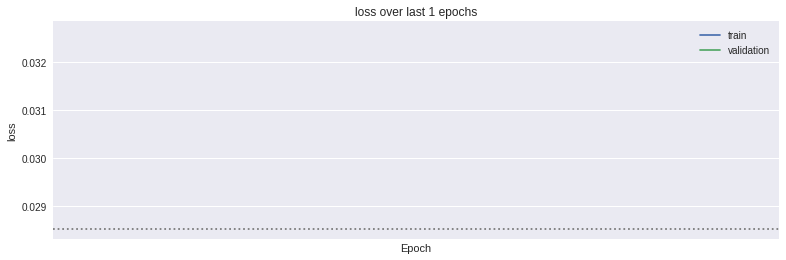

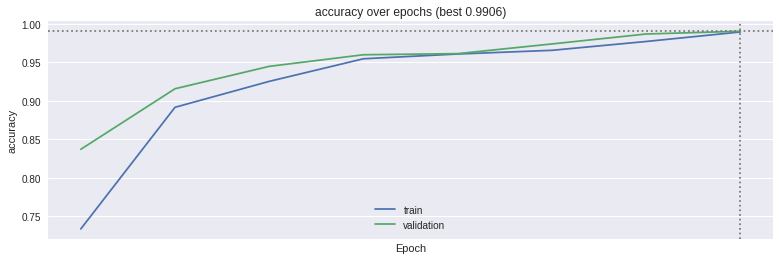

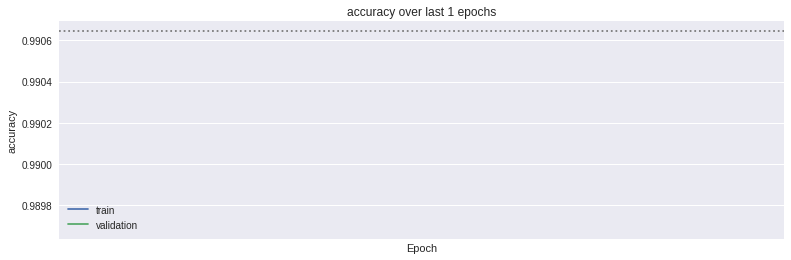


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 3ms/step - loss: 0.0276 - accuracy: 0.9910
Confusion matrix, without normalization
[[934   0   2]
 [  0 916   4]
 [  9  10 904]]

****** Validation data (unseen to model) *****

183/183 [==============================] - 1s 3ms/step - loss: 0.0599 - accuracy: 0.9781
Confusion matrix, without normalization
[[1891    0   53]
 [   0 1939    5]
 [   7   63 1874]]
Final Accuracy: 97.81 %

train : {'afib': 1598, 'nsr': 1646, 'afl': 401}
22544 18493 6771
After patient Scrambling: 20313


100%|██████████| 18493/18493 [00:00<00:00, 369219.50it/s]


test : {'afib': 181, 'nsr': 180, 'afl': 44}
2580 2027 720
After patient Scrambling: 2160


100%|██████████| 2027/2027 [00:00<00:00, 466187.10it/s]



#@#@#@#@#@ Working on FOLD: 3 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 5s 10ms/step - loss: 0.6825 - accuracy: 0.6804 - val_loss: 0.2636 - val_accuracy: 0.8944
Epoch 2/8
391/391 [==============================] - 4s 10ms/step - loss: 0.2568 - accuracy: 0.8974 - val_loss: 0.1914 - val_accuracy: 0.9250
Epoch 3/8
391/391 [==============================] - 4s 10ms/step - loss: 0.1667 - accuracy: 0.9383 - val_loss: 0.0926 - val_accuracy: 0.9686
Epoch 4/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0837 - accuracy: 0.9717 - val_loss: 0.0654 - val_accuracy: 0.9762
Epoch 5/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0670 - accuracy: 0.9780 - val_loss: 0.0878 - val_accuracy: 0.9647
Epoch 6/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0572 - accuracy: 0.9797 - val_loss: 0.0238 - val_accuracy: 0.9946
Epoch 7/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0298 - accuracy: 0.9905 - val_loss: 0.0117 - val_accuracy: 0.9960
Epoch 

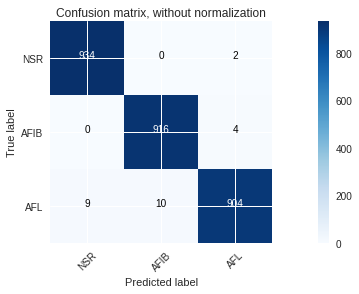

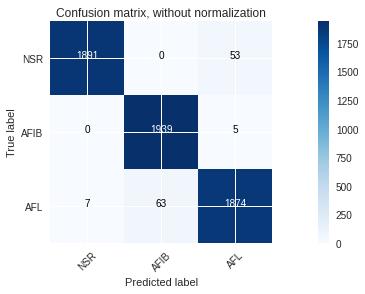

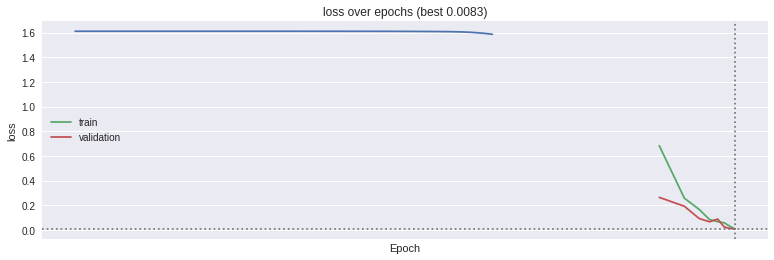

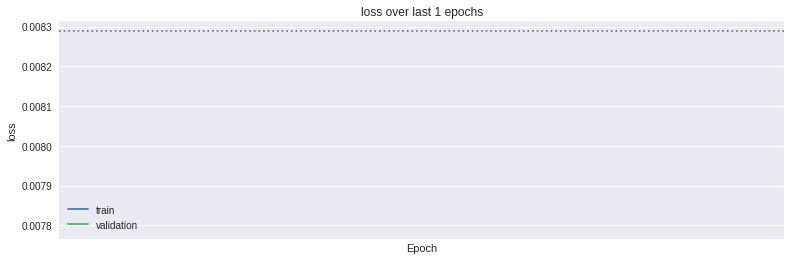

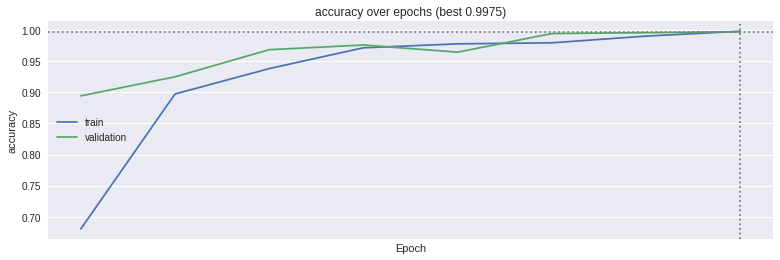

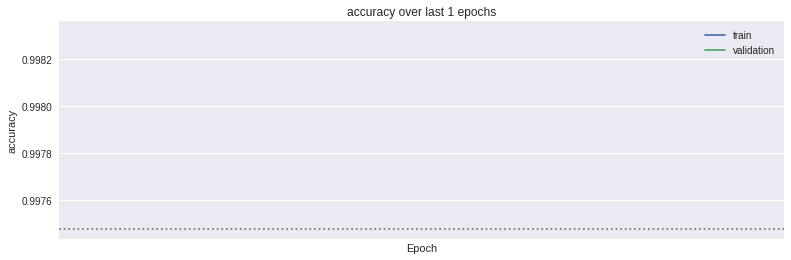


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 2ms/step - loss: 0.0064 - accuracy: 0.9986
Confusion matrix, without normalization
[[940   0   0]
 [  0 921   1]
 [  0   3 909]]

****** Validation data (unseen to model) *****

191/191 [==============================] - 1s 3ms/step - loss: 0.0776 - accuracy: 0.9732
Confusion matrix, without normalization
[[1991    0   36]
 [   0 2002   25]
 [  18   84 1925]]
Final Accuracy: 97.32 %

train : {'afib': 1601, 'nsr': 1647, 'afl': 397}
22597 18505 6601
After patient Scrambling: 19803


100%|██████████| 18505/18505 [00:00<00:00, 505152.01it/s]


test : {'afib': 178, 'nsr': 179, 'afl': 48}
2527 2015 890
After patient Scrambling: 2670


100%|██████████| 2015/2015 [00:00<00:00, 651721.36it/s]



#@#@#@#@#@ Working on FOLD: 4 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 5s 12ms/step - loss: 0.4920 - accuracy: 0.8077 - val_loss: 0.2491 - val_accuracy: 0.8959
Epoch 2/8
391/391 [==============================] - 4s 10ms/step - loss: 0.2021 - accuracy: 0.9206 - val_loss: 0.1702 - val_accuracy: 0.9380
Epoch 3/8
391/391 [==============================] - 4s 10ms/step - loss: 0.1306 - accuracy: 0.9528 - val_loss: 0.0849 - val_accuracy: 0.9719
Epoch 4/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0699 - accuracy: 0.9749 - val_loss: 0.0561 - val_accuracy: 0.9802
Epoch 5/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0586 - accuracy: 0.9780 - val_loss: 0.0526 - val_accuracy: 0.9787
Epoch 6/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0488 - accuracy: 0.9812 - val_loss: 0.0279 - val_accuracy: 0.9899
Epoch 7/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0266 - accuracy: 0.9909 - val_loss: 0.0107 - val_accuracy: 0.9968
Epoch 

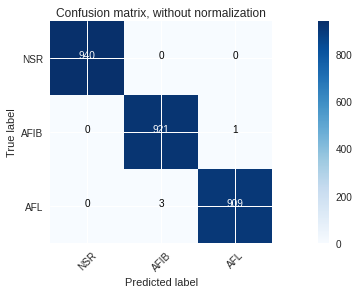

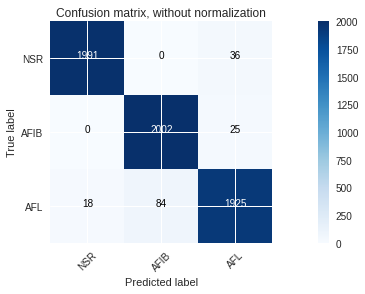

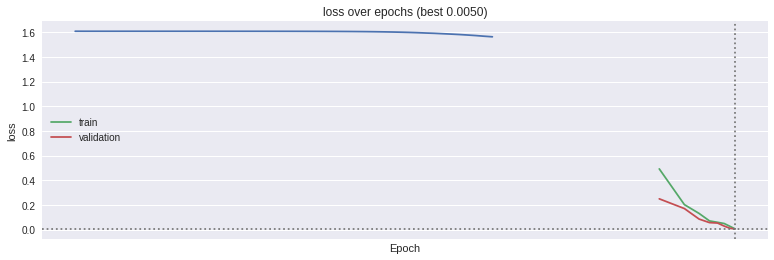

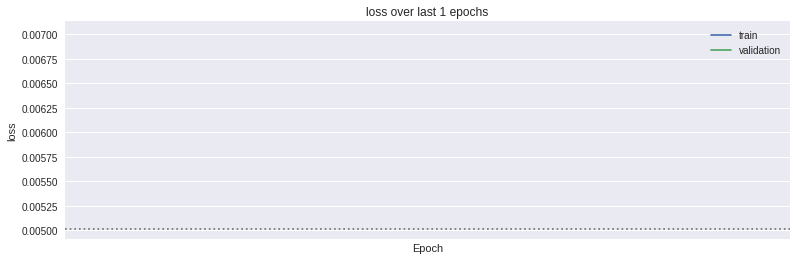

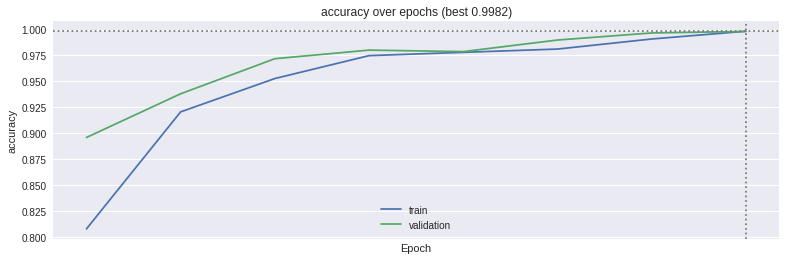

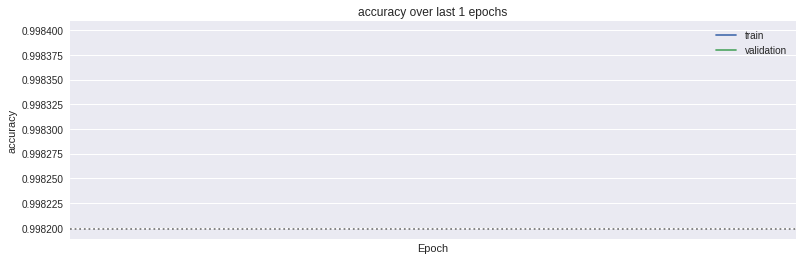


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 3ms/step - loss: 0.0048 - accuracy: 0.9993
Confusion matrix, without normalization
[[910   0   0]
 [  0 920   1]
 [  0   1 944]]

****** Validation data (unseen to model) *****

189/189 [==============================] - 1s 3ms/step - loss: 0.1858 - accuracy: 0.9568
Confusion matrix, without normalization
[[2015    0    0]
 [   0 1870  145]
 [  18   98 1899]]
Final Accuracy: 95.67999999999999 %

train : {'afib': 1612, 'nsr': 1639, 'afl': 394}
22717 18466 6641
After patient Scrambling: 19923


100%|██████████| 18466/18466 [00:00<00:00, 548744.67it/s]


test : {'afib': 167, 'nsr': 187, 'afl': 51}
2407 2054 850
After patient Scrambling: 2550


100%|██████████| 2054/2054 [00:00<00:00, 811520.39it/s]



#@#@#@#@#@ Working on FOLD: 5 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
390/390 [==============================] - 4s 10ms/step - loss: 0.5311 - accuracy: 0.7835 - val_loss: 0.2772 - val_accuracy: 0.8874
Epoch 2/8
390/390 [==============================] - 4s 10ms/step - loss: 0.2301 - accuracy: 0.9078 - val_loss: 0.2229 - val_accuracy: 0.9141
Epoch 3/8
390/390 [==============================] - 4s 10ms/step - loss: 0.1276 - accuracy: 0.9511 - val_loss: 0.0619 - val_accuracy: 0.9787
Epoch 4/8
390/390 [==============================] - 4s 10ms/step - loss: 0.0575 - accuracy: 0.9803 - val_loss: 0.0410 - val_accuracy: 0.9874
Epoch 5/8
390/390 [==============================] - 4s 10ms/step - loss: 0.0474 - accuracy: 0.9838 - val_loss: 0.0401 - val_accuracy: 0.9874
Epoch 6/8
390/390 [==============================] - 4s 10ms/step - loss: 0.0639 - accuracy: 0.9778 - val_loss: 0.1040 - val_accuracy: 0.9606
Epoch 7/8
390/390 [==============================] - 4s 10ms/step - loss: 0.0319 - accuracy: 0.9887 - val_loss: 0.0133 - val_accuracy: 0.9953
Epoch 

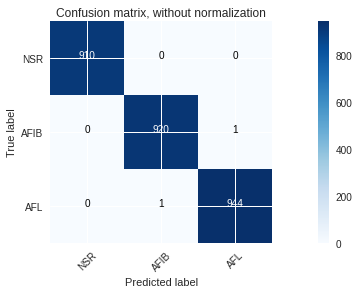

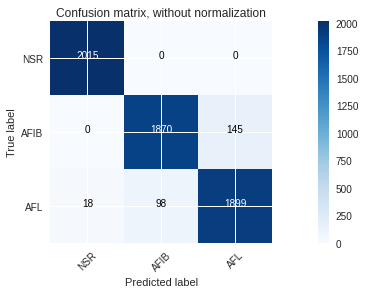

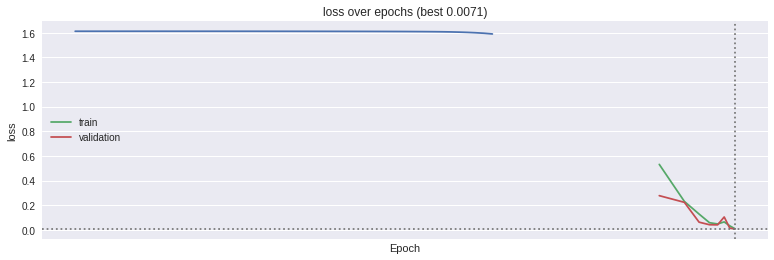

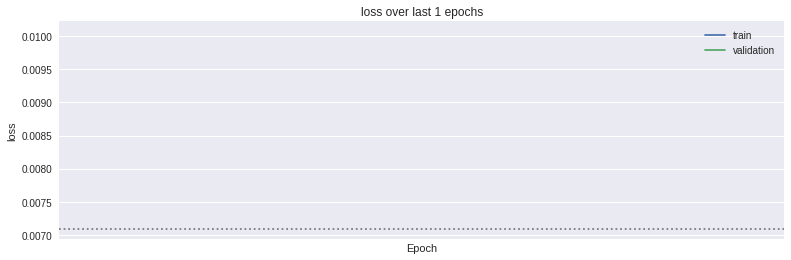

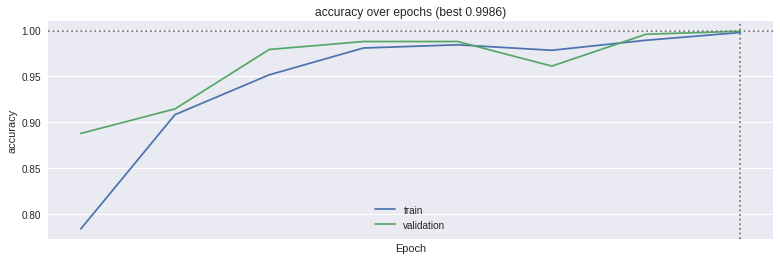

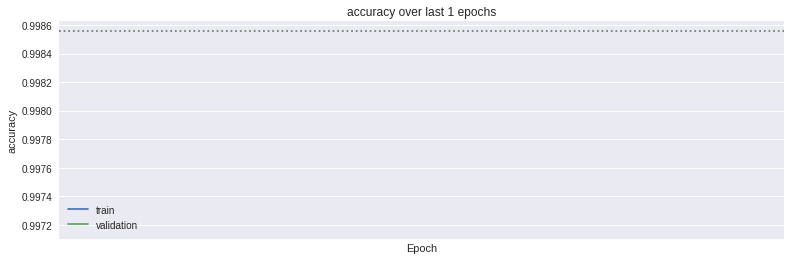


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 3ms/step - loss: 0.0063 - accuracy: 0.9986
Confusion matrix, without normalization
[[949   0   0]
 [  0 886   1]
 [  2   1 931]]

****** Validation data (unseen to model) *****

193/193 [==============================] - 1s 3ms/step - loss: 0.1232 - accuracy: 0.9662
Confusion matrix, without normalization
[[2008    0   46]
 [   0 1923  131]
 [  28    3 2023]]
Final Accuracy: 96.61999999999999 %

train : {'afib': 1601, 'nsr': 1640, 'afl': 404}
22603 18418 6844
After patient Scrambling: 20532


100%|██████████| 18418/18418 [00:00<00:00, 423772.12it/s]


test : {'afib': 178, 'nsr': 186, 'afl': 41}
2521 2102 647
After patient Scrambling: 1941


100%|██████████| 2102/2102 [00:00<00:00, 426099.61it/s]



#@#@#@#@#@ Working on FOLD: 6 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
389/389 [==============================] - 5s 12ms/step - loss: 0.5166 - accuracy: 0.7874 - val_loss: 0.2776 - val_accuracy: 0.8907
Epoch 2/8
389/389 [==============================] - 4s 10ms/step - loss: 0.2048 - accuracy: 0.9209 - val_loss: 0.1622 - val_accuracy: 0.9410
Epoch 3/8
389/389 [==============================] - 4s 10ms/step - loss: 0.1074 - accuracy: 0.9624 - val_loss: 0.0887 - val_accuracy: 0.9692
Epoch 4/8
389/389 [==============================] - 4s 10ms/step - loss: 0.0471 - accuracy: 0.9847 - val_loss: 0.0444 - val_accuracy: 0.9830
Epoch 5/8
389/389 [==============================] - 4s 10ms/step - loss: 0.0364 - accuracy: 0.9882 - val_loss: 0.0575 - val_accuracy: 0.9823
Epoch 6/8
389/389 [==============================] - 4s 10ms/step - loss: 0.0399 - accuracy: 0.9864 - val_loss: 0.0354 - val_accuracy: 0.9877
Epoch 7/8
389/389 [==============================] - 4s 10ms/step - loss: 0.0197 - accuracy: 0.9936 - val_loss: 0.0201 - val_accuracy: 0.9942
Epoch 

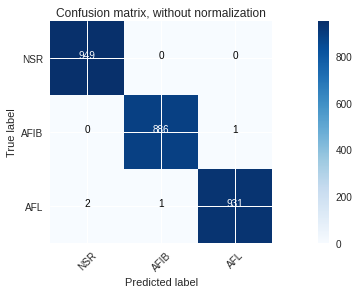

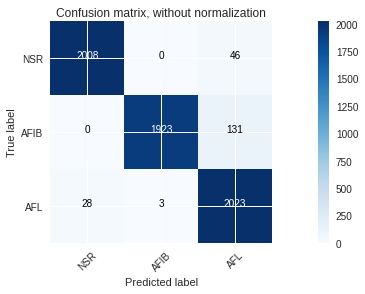

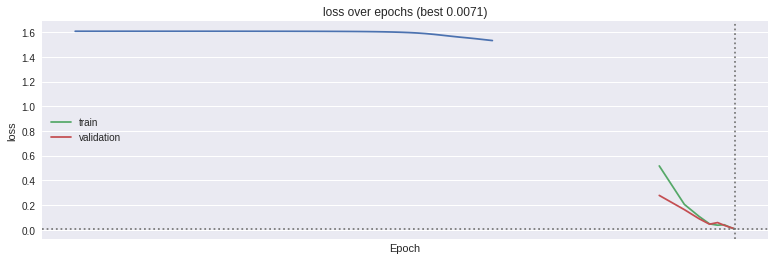

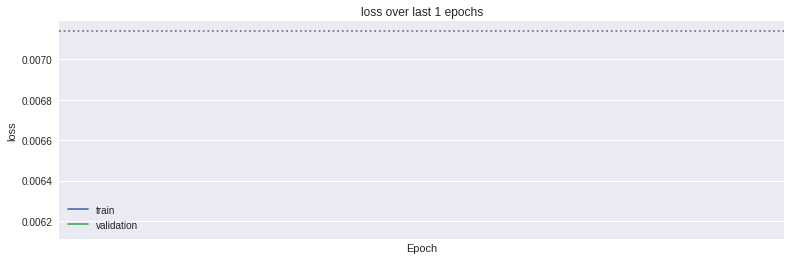

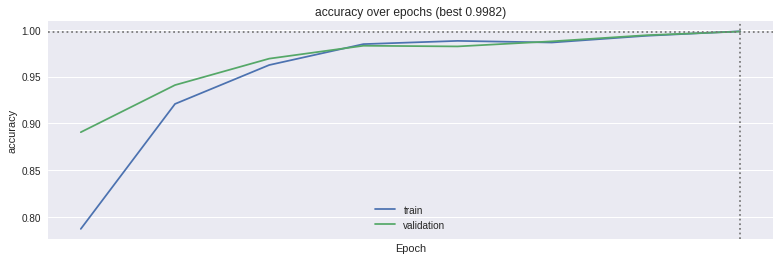

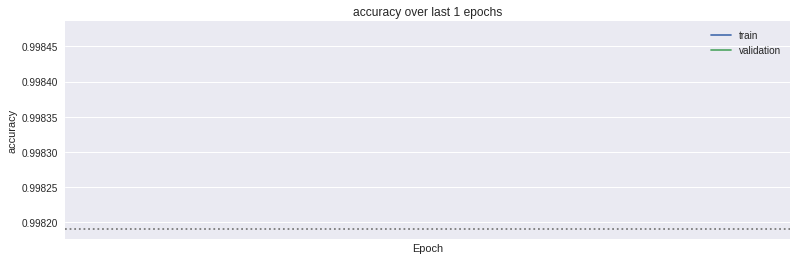


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 2ms/step - loss: 0.0057 - accuracy: 0.9986
Confusion matrix, without normalization
[[907   0   0]
 [  0 950   0]
 [  1   3 902]]

****** Validation data (unseen to model) *****

182/182 [==============================] - 1s 3ms/step - loss: 0.3989 - accuracy: 0.9332
Confusion matrix, without normalization
[[1844    0   97]
 [   0 1841  100]
 [   0  192 1749]]
Final Accuracy: 93.32000000000001 %

train : {'afib': 1609, 'nsr': 1637, 'afl': 399}
22766 18391 6728
After patient Scrambling: 20184


100%|██████████| 18391/18391 [00:00<00:00, 528440.01it/s]


test : {'afib': 170, 'nsr': 189, 'afl': 46}
2358 2129 763
After patient Scrambling: 2289


100%|██████████| 2129/2129 [00:00<00:00, 507858.34it/s]



#@#@#@#@#@ Working on FOLD: 7 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
388/388 [==============================] - 5s 12ms/step - loss: 0.7351 - accuracy: 0.7458 - val_loss: 0.2479 - val_accuracy: 0.9021
Epoch 2/8
388/388 [==============================] - 4s 10ms/step - loss: 0.2403 - accuracy: 0.9043 - val_loss: 0.2225 - val_accuracy: 0.9181
Epoch 3/8
388/388 [==============================] - 4s 10ms/step - loss: 0.1677 - accuracy: 0.9373 - val_loss: 0.1224 - val_accuracy: 0.9532
Epoch 4/8
388/388 [==============================] - 4s 10ms/step - loss: 0.1016 - accuracy: 0.9639 - val_loss: 0.0865 - val_accuracy: 0.9699
Epoch 5/8
388/388 [==============================] - 4s 10ms/step - loss: 0.0805 - accuracy: 0.9710 - val_loss: 0.1157 - val_accuracy: 0.9540
Epoch 6/8
388/388 [==============================] - 4s 10ms/step - loss: 0.0712 - accuracy: 0.9743 - val_loss: 0.0434 - val_accuracy: 0.9851
Epoch 7/8
388/388 [==============================] - 4s 10ms/step - loss: 0.0318 - accuracy: 0.9897 - val_loss: 0.0175 - val_accuracy: 0.9942
Epoch 

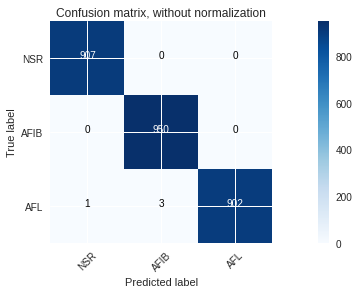

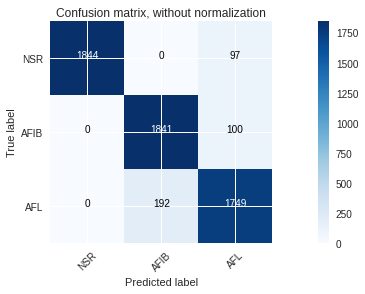

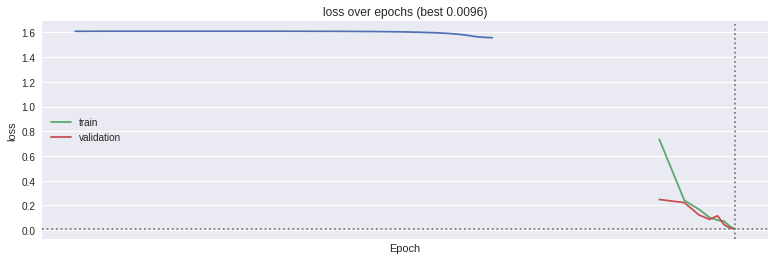

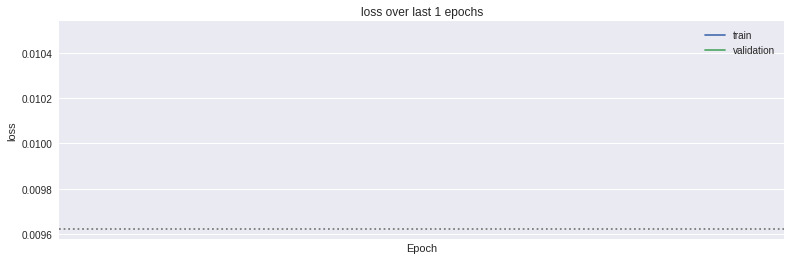

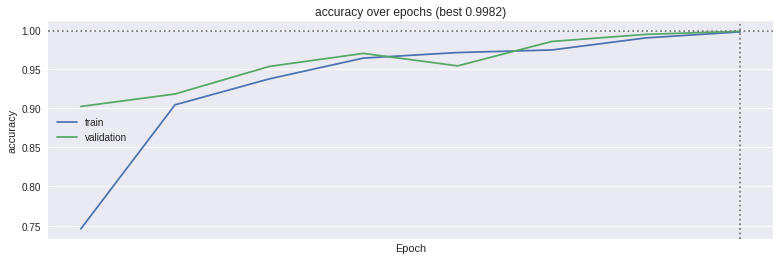

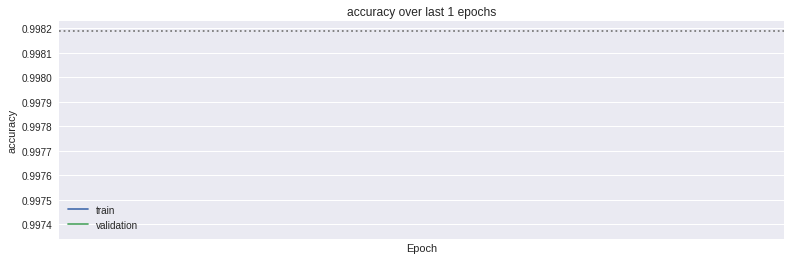


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 3ms/step - loss: 0.0097 - accuracy: 0.9975
Confusion matrix, without normalization
[[947   0   0]
 [  0 920   1]
 [  0   6 885]]

****** Validation data (unseen to model) *****

200/200 [==============================] - 1s 3ms/step - loss: 0.1758 - accuracy: 0.9452
Confusion matrix, without normalization
[[2127    0    2]
 [   0 2076   53]
 [  13  282 1834]]
Final Accuracy: 94.52000000000001 %

train : {'afib': 1597, 'nsr': 1635, 'afl': 413}
22521 18333 6937
After patient Scrambling: 20811


100%|██████████| 18333/18333 [00:00<00:00, 505141.64it/s]


test : {'afib': 182, 'nsr': 191, 'afl': 32}
2603 2187 554
After patient Scrambling: 1662


100%|██████████| 2187/2187 [00:00<00:00, 458715.95it/s]



#@#@#@#@#@ Working on FOLD: 8 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
387/387 [==============================] - 4s 10ms/step - loss: 0.5690 - accuracy: 0.7631 - val_loss: 0.2234 - val_accuracy: 0.9109
Epoch 2/8
387/387 [==============================] - 4s 10ms/step - loss: 0.1957 - accuracy: 0.9215 - val_loss: 0.1455 - val_accuracy: 0.9400
Epoch 3/8
387/387 [==============================] - 4s 10ms/step - loss: 0.1196 - accuracy: 0.9546 - val_loss: 0.0686 - val_accuracy: 0.9735
Epoch 4/8
387/387 [==============================] - 4s 10ms/step - loss: 0.0570 - accuracy: 0.9801 - val_loss: 0.0420 - val_accuracy: 0.9880
Epoch 5/8
387/387 [==============================] - 4s 10ms/step - loss: 0.0477 - accuracy: 0.9832 - val_loss: 0.0667 - val_accuracy: 0.9764
Epoch 6/8
387/387 [==============================] - 4s 10ms/step - loss: 0.0571 - accuracy: 0.9798 - val_loss: 0.1213 - val_accuracy: 0.9542
Epoch 7/8
387/387 [==============================] - 5s 12ms/step - loss: 0.0296 - accuracy: 0.9898 - val_loss: 0.0133 - val_accuracy: 0.9960
Epoch 

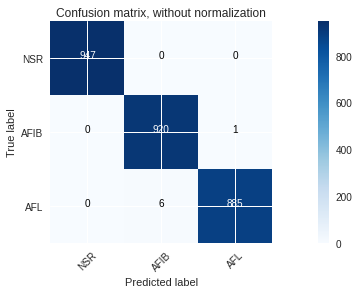

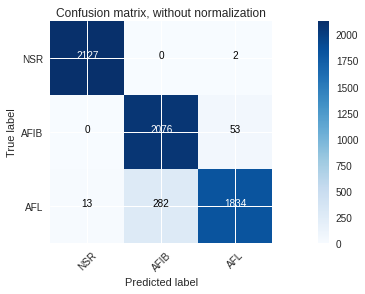

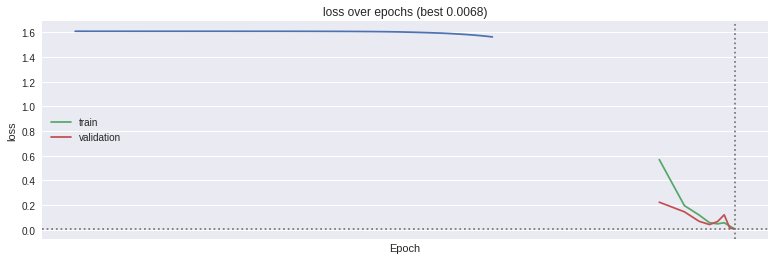

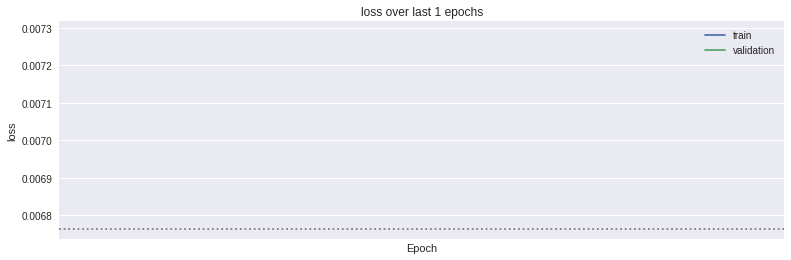

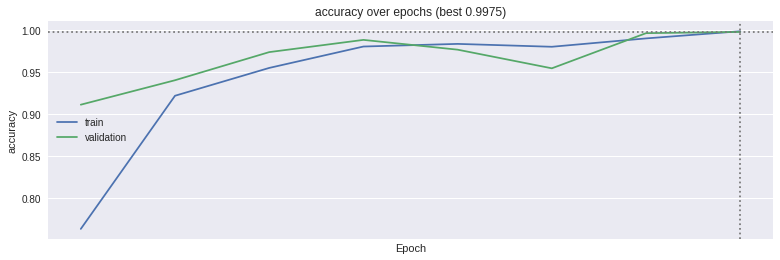

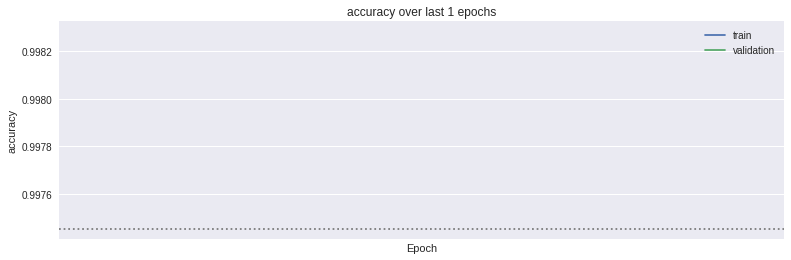


****** Val data (used to tune hyperparameters for model) *****

86/86 [==============================] - 0s 3ms/step - loss: 0.0071 - accuracy: 0.9985
Confusion matrix, without normalization
[[916   0   0]
 [  0 912   2]
 [  2   0 918]]

****** Validation data (unseen to model) *****

156/156 [==============================] - 1s 3ms/step - loss: 0.0687 - accuracy: 0.9795
Confusion matrix, without normalization
[[1659    0    3]
 [   0 1655    7]
 [  24   68 1570]]
Final Accuracy: 97.95 %

train : {'afib': 1606, 'nsr': 1646, 'afl': 393}
22685 18493 6640
After patient Scrambling: 19920


100%|██████████| 18493/18493 [00:00<00:00, 70976.25it/s]


test : {'afib': 173, 'nsr': 180, 'afl': 52}
2439 2027 851
After patient Scrambling: 2553


100%|██████████| 2027/2027 [00:00<00:00, 589874.02it/s]



#@#@#@#@#@ Working on FOLD: 9 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
391/391 [==============================] - 5s 12ms/step - loss: 0.6250 - accuracy: 0.7369 - val_loss: 0.2913 - val_accuracy: 0.8803
Epoch 2/8
391/391 [==============================] - 4s 10ms/step - loss: 0.2473 - accuracy: 0.9028 - val_loss: 0.3039 - val_accuracy: 0.8782
Epoch 3/8
391/391 [==============================] - 5s 12ms/step - loss: 0.1634 - accuracy: 0.9396 - val_loss: 0.1400 - val_accuracy: 0.9441
Epoch 4/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0844 - accuracy: 0.9708 - val_loss: 0.0711 - val_accuracy: 0.9740
Epoch 5/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0695 - accuracy: 0.9759 - val_loss: 0.0938 - val_accuracy: 0.9650
Epoch 6/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0709 - accuracy: 0.9755 - val_loss: 0.0640 - val_accuracy: 0.9766
Epoch 7/8
391/391 [==============================] - 4s 10ms/step - loss: 0.0319 - accuracy: 0.9893 - val_loss: 0.0197 - val_accuracy: 0.9942
Epoch 

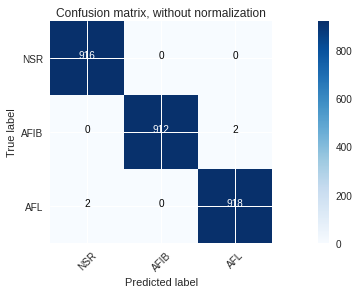

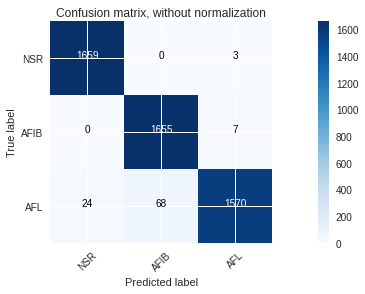

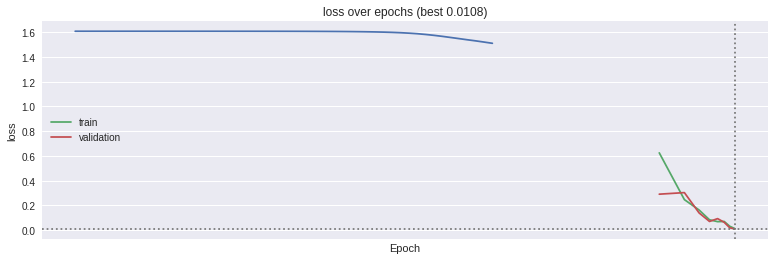

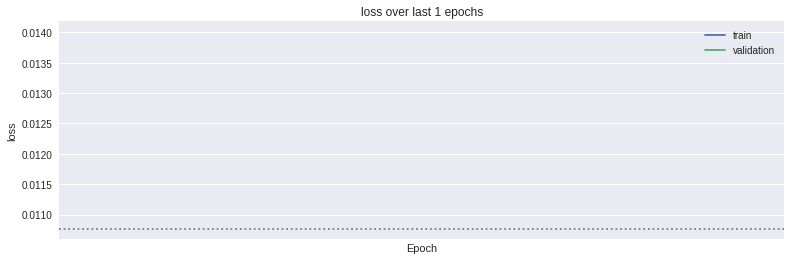

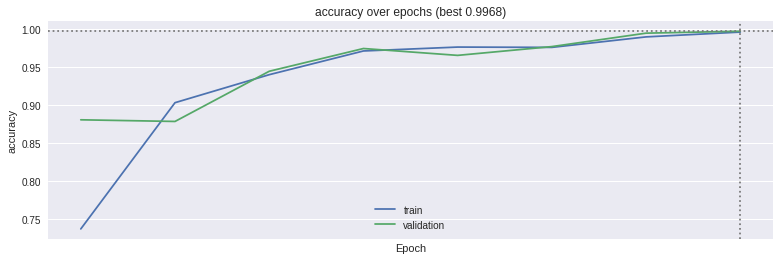

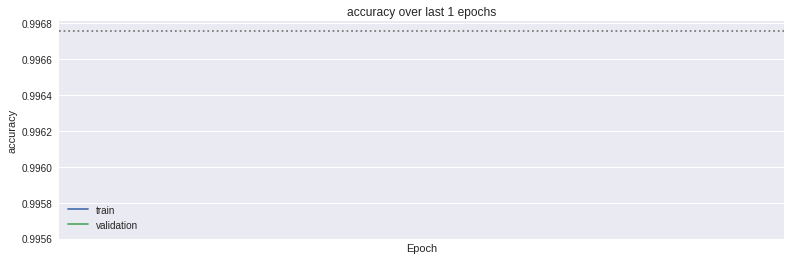


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 2ms/step - loss: 0.0119 - accuracy: 0.9975
Confusion matrix, without normalization
[[919   0   0]
 [  0 957   0]
 [  2   5 891]]

****** Validation data (unseen to model) *****

191/191 [==============================] - 1s 3ms/step - loss: 0.2454 - accuracy: 0.9301
Confusion matrix, without normalization
[[1946    0   81]
 [   0 1907  120]
 [  24  200 1803]]
Final Accuracy: 93.01 %

train : {'afib': 1608, 'nsr': 1642, 'afl': 395}
22727 18488 6628
After patient Scrambling: 19884


100%|██████████| 18488/18488 [00:00<00:00, 386766.15it/s]


test : {'afib': 171, 'nsr': 184, 'afl': 50}
2397 2032 863
After patient Scrambling: 2589


100%|██████████| 2032/2032 [00:00<00:00, 648172.92it/s]



#@#@#@#@#@ Working on FOLD: 10 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
390/390 [==============================] - 5s 12ms/step - loss: 0.5931 - accuracy: 0.7525 - val_loss: 0.2667 - val_accuracy: 0.8958
Epoch 2/8
390/390 [==============================] - 4s 10ms/step - loss: 0.2471 - accuracy: 0.9050 - val_loss: 0.1739 - val_accuracy: 0.9463
Epoch 3/8
390/390 [==============================] - 4s 10ms/step - loss: 0.1543 - accuracy: 0.9456 - val_loss: 0.1046 - val_accuracy: 0.9676
Epoch 4/8
390/390 [==============================] - 4s 10ms/step - loss: 0.0902 - accuracy: 0.9689 - val_loss: 0.0693 - val_accuracy: 0.9755
Epoch 5/8
390/390 [==============================] - 4s 10ms/step - loss: 0.0784 - accuracy: 0.9730 - val_loss: 0.1214 - val_accuracy: 0.9539
Epoch 6/8
390/390 [==============================] - 4s 10ms/step - loss: 0.0667 - accuracy: 0.9771 - val_loss: 0.0590 - val_accuracy: 0.9820
Epoch 7/8
390/390 [==============================] - 4s 10ms/step - loss: 0.0387 - accuracy: 0.9867 - val_loss: 0.0175 - val_accuracy: 0.9957
Epoch 

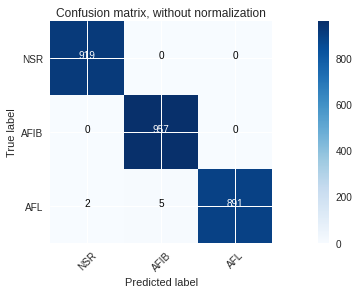

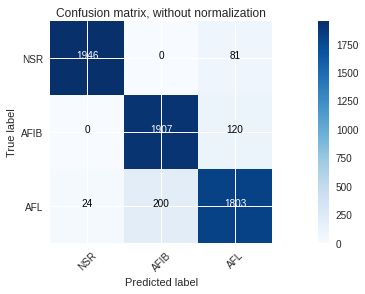

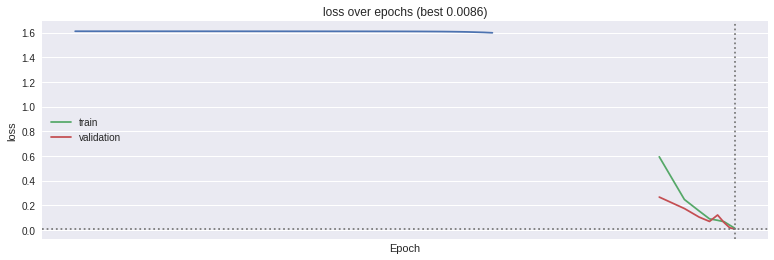

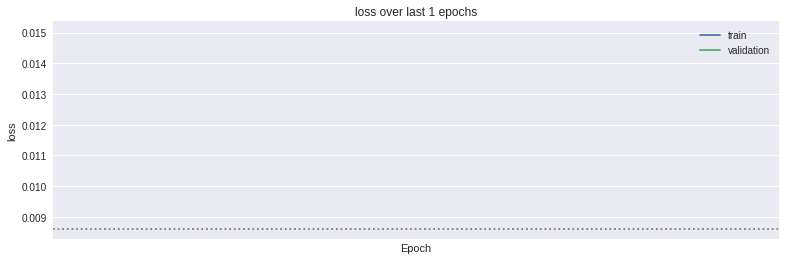

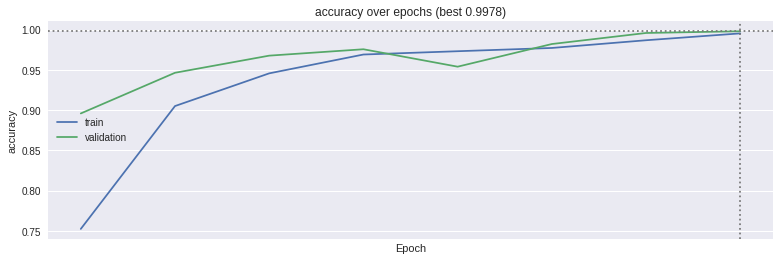

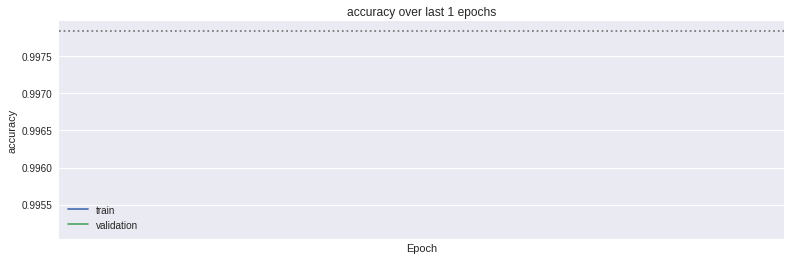


****** Val data (used to tune hyperparameters for model) *****

87/87 [==============================] - 0s 3ms/step - loss: 0.0106 - accuracy: 0.9975
Confusion matrix, without normalization
[[907   0   0]
 [  0 909   0]
 [  1   6 950]]

****** Validation data (unseen to model) *****

191/191 [==============================] - 1s 3ms/step - loss: 0.0513 - accuracy: 0.9846
Confusion matrix, without normalization
[[1990    0   42]
 [   0 2022   10]
 [   0   42 1990]]
Final Accuracy: 98.46000000000001 %

10 fold acc: [97.15, 97.81, 97.32, 95.67999999999999, 96.61999999999999, 93.32000000000001, 94.52000000000001, 97.95, 93.01, 98.46000000000001]


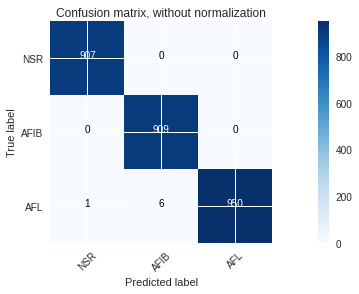

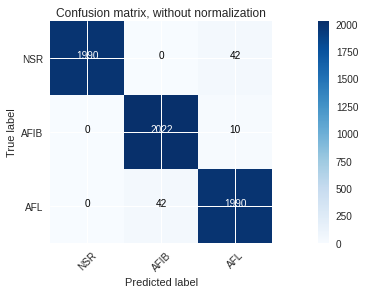

In [ ]:
# scikit-learn k-fold cross-validation
data=all_subjects

# prepare cross validation
kfold = KFold(10,shuffle=True,random_state=42)
all_fold_acc = []
# enumerate splits
count=1
for train, test in kfold.split(data):  
  full_train_set = extractor("train",train)
  full_test_set = extractor("test",test)
  print("\n#@#@#@#@#@ Working on FOLD:",count,"#@#@#@#@#@\n")
  accuracy_1_fold = train_1_fold(full_train_set,full_test_set,5,8)
  all_fold_acc.append(accuracy_1_fold)
  count+=1
  #1 fold done call rest part in function to complete your k fold cv
  
print("10 fold acc:",all_fold_acc)

### Testing on Other Datasets

In [ ]:
# import glob
# m_resnet_model = get_resnet_model(10)
# m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")

# path = r'/content/musecare_rr_intervals' # use your path
# all_files = glob.glob(path + "/*.csv")

# li = []
# name = []
# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=None)
#     one_list=df.iloc[0]
#     new_df=pd.DataFrame()
#     for i in range(0,len(one_list)):
#       if(one_list[i]!=one_list[i+1]):
#         one_list=one_list[i+1:i+101]
#         one_list=one_list/1000
#         one_list.reset_index(inplace=True,drop=True)
#         detrended_rri = signal.detrend(one_list, axis= -1, type='constant', bp=0, overwrite_data=False).tolist()
        
#         new_df=new_df.append(pd.DataFrame(detrended_rri).transpose())
#         break
#     li.append(new_df)
#     name.append(filename)

# test_data = pd.concat(li, axis=0, ignore_index=True)
# test_data['filename']=name

# print(test_data.shape[0] - test_data.dropna().shape[0])
# #hence 81 files have null values, will drop them

# test_data=test_data.dropna()
# test_data.reset_index(inplace=True,drop=True)

# X_ckecker=test_data.iloc[:,:-1].values
# preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

# test_data['predicted_class']=preds
# dct= {0:'nsr', 1:'afib', 2:'afl'}
# test_data=test_data.replace({"predicted_class": dct})
# test_data['predicted_class'].value_counts()

In [ ]:
# test_data.to_csv("result_arr_ppg_RRi.csv",index=False)

### Testing on PTB Diagnostic ECG database

In [ ]:
# !wget "https://www.physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip"

--2022-04-06 09:13:40--  https://www.physionet.org/static/published-projects/ptbdb/ptb-diagnostic-ecg-database-1.0.0.zip
Resolving www.physionet.org (www.physionet.org)... 18.18.42.54
Connecting to www.physionet.org (www.physionet.org)|18.18.42.54|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1790456359 (1.7G) [application/zip]
Saving to: ‘ptb-diagnostic-ecg-database-1.0.0.zip.1’

    ptb-diagnostic-   3%[                    ]  63.44M  52.7MB/s               ^C


Each csv file includes information of 15 simultaneously measured signals:12 leads (i, ii, iii, avr, avl, avf, v1, v2, v3, v4, v5, v6) together with the 3 Frank lead ECGs (vx, vy, vz).
The sampling frequency of ECG is 1000Hz.

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/
!pip install wfdb
import wfdb #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import sys
import glob
import os
from glob import glob
PATH = "/content/physionet.org/files/ptbdb/1.0.0/"
sys.path.append(os.path.abspath(PATH))

nsr_patients =['patient104/s0306lre','patient105/s0303lre','patient116/s0302lre','patient117/s0291lre','patient117/s0292lre',
      'patient121/s0311lre','patient122/s0312lre','patient131/s0273lre','patient150/s0287lre','patient155/s0301lre',
      'patient156/s0299lre','patient165/s0322lre','patient165/s0323lre','patient166/s0275lre','patient169/s0328lre',
      'patient169/s0329lre','patient170/s0274lre','patient172/s0304lre','patient173/s0305lre','patient174/s0300lre',
      'patient174/s0324lre','patient174/s0325lre','patient180/s0374lre','patient180/s0475_re','patient180/s0476_re',
      'patient180/s0477_re','patient180/s0490_re','patient180/s0545_re','patient180/s0561_re','patient182/s0308lre',
      'patient184/s0363lre','patient185/s0336lre','patient198/s0402lre','patient198/s0415lre','patient214/s0436_re',
      'patient229/s0452_re','patient229/s0453_re','patient233/s0457_re','patient233/s0458_re','patient233/s0459_re',
      'patient233/s0482_re','patient233/s0483_re','patient234/s0460_re','patient235/s0461_re','patient236/s0462_re',
      'patient236/s0463_re','patient236/s0464_re','patient237/s0465_re','patient238/s0466_re','patient239/s0467_re',
      'patient240/s0468_re','patient241/s0469_re','patient241/s0470_re','patient242/s0471_re','patient243/s0472_re',
      'patient244/s0473_re','patient245/s0474_re','patient245/s0480_re','patient246/s0478_re','patient247/s0479_re',
      'patient248/s0481_re','patient251/s0486_re','patient251/s0503_re','patient251/s0506_re','patient252/s0487_re',
      'patient255/s0491_re','patient260/s0496_re','patient263/s0499_re','patient264/s0500_re','patient266/s0502_re',
      'patient267/s0504_re','patient276/s0526_re','patient277/s0527_re','patient279/s0531_re','patient279/s0532_re',
      'patient279/s0533_re','patient279/s0534_re','patient284/s0543_re','patient284/s0551_re','patient284/s0552_re']

In [ ]:
files = nsr_patients

for i in tqdm(range(0,len(files))):
	recordname=PATH+str(files[i])+'.hea'
	
	recordname_new=recordname[-23:-4] #Extracting just the filename part (will differ from database to database)
	# print(recordname_new)
	record = wfdb.rdsamp(PATH+recordname_new) # rdsamp() returns the signal as a numpy array  
	record=np.asarray(record[0])
	path=PATH+recordname_new+".csv"
	np.savetxt(path,record,delimiter=",") #Writing the CSV for each record
	
print("\nAll files done!")

100%|██████████| 80/80 [02:15<00:00,  1.70s/it]


All files done!


In [ ]:
# With normal flatten layer at the end, without batch Norm.
methods=["interpolation","FFT","poly","numpy"]
m_resnet_model = get_resnet_model(5)
m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
for way in methods:
  print("Using",way,"method of Resampling\n")
  filenames=[]
  li=[]
  for i in tqdm(range(0,len(files))):
    recordname=PATH+str(files[i])+'.csv'
    df=pd.read_csv(recordname,header=None)
    lead_II = df.iloc[:,1] #lead II
    lead_II = nk.signal_resample(lead_II, method=way,
                                              sampling_rate=1000, desired_sampling_rate=500)
    _, rpeaks = nk.ecg_peaks(lead_II, sampling_rate=500)
    rrintervals = rpeaks['ECG_R_Peaks']

    rr_diff=np.diff(rrintervals)/1000
    detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
    new_df=pd.DataFrame(detrended_rri).transpose()
    li.append(new_df)
    filenames.append(files[i])
    
  test_data = pd.concat(li, axis=0, ignore_index=True)
  test_data=test_data.loc[:,:99]
  test_data['filename']=filenames 

  print("Dropping:",test_data.shape[0] - test_data.dropna().shape[0]," rows.\n")
  #hence 81 files have null values, will drop them
 
  test_data=test_data.dropna()
  test_data.reset_index(inplace=True,drop=True)

  X_ckecker=test_data.iloc[:,:-1].values
  preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

  test_data['predicted_class']=preds
  dct= {0:'nsr', 1:'Afib',2:'Afl'}
  test_data=test_data.replace({"predicted_class": dct})
  print("#### RESULTS ####\n",test_data['predicted_class'].value_counts(),"\n")

Using interpolation method of Resampling



100%|██████████| 80/80 [00:30<00:00,  2.65it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     55
Afl     13
Afib    10
Name: predicted_class, dtype: int64 

Using FFT method of Resampling



100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     55
Afl     14
Afib     9
Name: predicted_class, dtype: int64 

Using poly method of Resampling



100%|██████████| 80/80 [00:35<00:00,  2.23it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     55
Afl     14
Afib     9
Name: predicted_class, dtype: int64 

Using numpy method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.70it/s]

Dropping: 2  rows.

#### RESULTS ####
 nsr     55
Afl     12
Afib    11
Name: predicted_class, dtype: int64 



In [ ]:
#with globalavg pooling & Without Batch normalization and 
methods=["interpolation","FFT","poly","numpy"]
m_resnet_model = get_resnet_model(5)
m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
for way in methods:
  print("Using",way,"method of Resampling\n")
  filenames=[]
  li=[]
  for i in tqdm(range(0,len(files))):
    recordname=PATH+str(files[i])+'.csv'
    df=pd.read_csv(recordname,header=None)
    lead_II = df.iloc[:,1] #lead II
    lead_II = nk.signal_resample(lead_II, method=way,
                                              sampling_rate=1000, desired_sampling_rate=500)
    _, rpeaks = nk.ecg_peaks(lead_II, sampling_rate=500)
    rrintervals = rpeaks['ECG_R_Peaks']

    rr_diff=np.diff(rrintervals)/1000
    detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
    new_df=pd.DataFrame(detrended_rri).transpose()
    li.append(new_df)
    filenames.append(files[i])
    
  test_data = pd.concat(li, axis=0, ignore_index=True)
  test_data=test_data.loc[:,:99]
  test_data['filename']=filenames 

  print("Dropping:",test_data.shape[0] - test_data.dropna().shape[0]," rows.\n")
  #hence 81 files have null values, will drop them
 
  test_data=test_data.dropna()
  test_data.reset_index(inplace=True,drop=True)

  X_ckecker=test_data.iloc[:,:-1].values
  preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

  test_data['predicted_class']=preds
  dct= {0:'nsr', 1:'Afib',2:'Afl'}
  test_data=test_data.replace({"predicted_class": dct})
  print("#### RESULTS ####\n",test_data['predicted_class'].value_counts(),"\n")

Using interpolation method of Resampling



100%|██████████| 80/80 [00:30<00:00,  2.66it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     58
Afib    16
Afl      4
Name: predicted_class, dtype: int64 

Using FFT method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.67it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     58
Afib    15
Afl      5
Name: predicted_class, dtype: int64 

Using poly method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.71it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     58
Afib    15
Afl      5
Name: predicted_class, dtype: int64 

Using numpy method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.68it/s]

Dropping: 2  rows.

#### RESULTS ####
 nsr     58
Afib    17
Afl      3
Name: predicted_class, dtype: int64 



In [ ]:
### WITH BATCH NORMALIZATION

methods=["interpolation","FFT","poly","numpy"]
m_resnet_model = get_resnet_model(5)
m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights.hdf5")
for way in methods:
  print("Using",way,"method of Resampling\n")
  filenames=[]
  li=[]
  for i in tqdm(range(0,len(files))):
    recordname=PATH+str(files[i])+'.csv'
    df=pd.read_csv(recordname,header=None)
    lead_II = df.iloc[:,1] #lead II
    lead_II = nk.signal_resample(lead_II, method=way,
                                              sampling_rate=1000, desired_sampling_rate=500)
    _, rpeaks = nk.ecg_peaks(lead_II, sampling_rate=500)
    rrintervals = rpeaks['ECG_R_Peaks']

    rr_diff=np.diff(rrintervals)/1000
    detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
    new_df=pd.DataFrame(detrended_rri).transpose()
    li.append(new_df)
    filenames.append(files[i])
    
  test_data = pd.concat(li, axis=0, ignore_index=True)
  test_data=test_data.loc[:,:99]
  test_data['filename']=filenames 

  print("Dropping:",test_data.shape[0] - test_data.dropna().shape[0]," rows.\n")
  #hence 81 files have null values, will drop them
 
  test_data=test_data.dropna()
  test_data.reset_index(inplace=True,drop=True)

  X_ckecker=test_data.iloc[:,:-1].values
  preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

  test_data['predicted_class']=preds
  dct= {0:'nsr', 1:'Afib',2:'Afl'}
  test_data=test_data.replace({"predicted_class": dct})
  print("#### RESULTS ####\n",test_data['predicted_class'].value_counts(),"\n")

Using interpolation method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.68it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     45
Afib    18
Afl     15
Name: predicted_class, dtype: int64 

Using FFT method of Resampling



100%|██████████| 80/80 [00:29<00:00,  2.69it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     44
Afib    19
Afl     15
Name: predicted_class, dtype: int64 

Using poly method of Resampling



100%|██████████| 80/80 [00:34<00:00,  2.34it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     45
Afib    18
Afl     15
Name: predicted_class, dtype: int64 

Using numpy method of Resampling



100%|██████████| 80/80 [00:40<00:00,  1.98it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr     44
Afib    19
Afl     15
Name: predicted_class, dtype: int64 

